In [3]:
import os
import math
import random
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import numpy as np
import copy 

GOOGLE_COLAB = False
data_dir = ''

!python -m spacy download en
!python -m spacy download de

# for tokenizing the english sentences
spacy_en = spacy.load('en')
# for tokenizing the german sentences
spacy_de = spacy.load('de')

if GOOGLE_COLAB:
    !pip install pytorch-nlp
    import os
    from google.colab import drive
    drive.mount('/content/gdrive') 
    data_dir = '/content/gdrive/My Drive/colab/translation-seq2seq/'
    os.listdir(data_dir)     

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/tnni/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/tnni/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/Users/tnni/anaconda3/lib/python3.7/site-packages/de_core_news_sm -->
/Users/tnni/anaconda3/lib/python3.7/site-packages/spacy/data/de
You can now load the model via spacy.load('de')


# Build dataset from Multi30k via TorchText

In [4]:
def tokenize_de(text):
    # tokenizes the german text into a list of strings(tokens) and reverse it
    # we are reversing the input sentences, as it is observed 
    # by reversing the inputs we will get better results
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]     # list[::-1] used to reverse the list


def tokenize_en(text):
    # tokenizes the english text into a list of strings(tokens)
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Make language objects
SRC_LANG = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TAR_LANG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

# Load Multi30k dataset
print('Loading Multi30k data...')
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC_LANG, TAR_LANG))
print('Finished!')

print("Number of training examples:", len(train_data.examples))
print("Number of validation examples:", len(valid_data.examples))
print("Number of testing examples:", len(test_data.examples))

source_sent_ex = ' '.join(reversed(vars(train_data.examples[0])['src']))
target_sent_ex = ' '.join(vars(train_data.examples[0])['trg'])
print("Example SOURCE sentence:", source_sent_ex)
print("Example TARGET sentence:", target_sent_ex)

Loading Multi30k data...
downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 3.50MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 591kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 886kB/s]


Finished!
Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
Example SOURCE sentence: zwei junge weiße männer sind im freien in der nähe vieler büsche .
Example TARGET sentence: two young , white males are outside near many bushes .


# Build vocab

In [7]:
print('Building vocabulary...')
SRC_LANG.build_vocab(train_data, min_freq=2) # Only include words occuring at least twice
TAR_LANG.build_vocab(train_data, min_freq=2) # Only include words occuring at least twice
print('Finished!')

print("Unique tokens in source (de) vocabulary:", len(SRC_LANG.vocab))
print("Unique tokens in target (en) vocabulary:", len(TAR_LANG.vocab))

Building vocabulary...
Finished!
Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


# Set the Batch size and device

In [8]:
# use gpu if available, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Loaded device:', device)

# create data iterators for the data 
# padding all the sentences to same length, replacing words by its index,
# bucketing (minimizes the amount of padding by grouping similar length sentences)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, device=device)

Loaded device: cpu


# Transformer Model

In [14]:
# Code base borrowed from https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).to(device)
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
    
        return output
    
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__() 
        # We set d_ff as a default to 256
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm
    
# EncoderLayer with one multi-head attention layer for the input 
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, heads, dropout):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# DecoderLayer: Use two Multihead-attention layers to decode output
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, heads, dropout):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout).to(device)
    
    def forward(self, x, e_outputs, src_mask, trg_mask):
            x2 = self.norm_1(x)
            x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
            x2 = self.norm_2(x)
            x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
            src_mask))
            x2 = self.norm_3(x)
            x = x + self.dropout_3(self.ff(x2))
            return x



def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output


def create_masks(input_seq, target_seq):
    input_pad = SRC_LANG.vocab.stoi['<pad>']
    # creates mask with 0s wherever there is padding in the input
    input_msk = (input_seq != input_pad).unsqueeze(1)
    
    # create mask as before
    target_pad = TAR_LANG.vocab.stoi['<pad>']
    target_msk = (target_seq != target_pad).byte().unsqueeze(1)
    size = target_seq.size(1) # get seq_len for matrix
    nopeak_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0).byte().to(device)
    target_msk = target_msk & nopeak_mask
    
    return input_msk, target_msk

# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# Embedder
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)


# Encoder: Embeds and encodes the input sentence
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, d_ff, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
# Decoder: Compares the encoded inputs and the outputs via multihead-attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, d_ff, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

# Transformer, puts the encoder and decoder module together
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, d_ff, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, d_ff, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, d_ff, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Evaluate Function

In [10]:
def evaluate(model, iterator):
    ''' 
    Evaluation loop for the model to evaluate.
    Args:
        model: A Seq2Seq model instance.
        iterator: A DataIterator to read the data.
        criterion: loss criterion.
    Returns:
        epoch_loss: Average loss for the validation set.
    '''
    #  some layers have different behavior during train/and evaluation (like BatchNorm, Dropout) so setting it matters.
    model.eval()
    # loss
    epoch_loss = 0

    # no_grad() ensures parameters arent optimized (this would be cheating)
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src.transpose(0,1)
            trg = batch.trg.transpose(0,1)
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input)
            
            # Forward pass
            preds = model(src, trg_input, src_mask, trg_mask)
            
            # Calculate loss
            preds_ = preds.view(-1, preds.size(-1))
            targets = trg[:, 1:].contiguous().view(-1)
            loss = criterion(preds_, targets)
            
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Train function

In [11]:
def train_one_epoch(iterator, print_every=100):
    ''' 
    Training loop which runs one epoch.
    Args:
        None
    Returns:
        epoch_loss: Average loss of the epoch.
    '''
    # Toggle train mode to adjust params
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        # Prepare batch
        src = batch.src.transpose(0,1)
        trg = batch.trg.transpose(0,1)
        trg_input = trg[:, :-1]
        src_mask, trg_mask = create_masks(src, trg_input)

        # Forward pass
        preds = model(src, trg_input, src_mask, trg_mask)

        # Perform backprop
        optim.zero_grad()
        preds_ = preds.view(-1, preds.size(-1))
        targets = trg[:, 1:].contiguous().view(-1)
        loss = criterion(preds_, targets)
        loss.backward()
        optim.step()
        
        # Save loss for epoch
        epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

# Util functions

In [12]:
import time
import pickle
from datetime import datetime

def get_timestamp_str():
    dateTimeObj = datetime.now()
    return str(dateTimeObj).replace(' ', '_')

def init_params(m):
    # Initialize params
    for p in m.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def count_parameters(model):
    '''Count the number of parameters in a PyTorch model'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Set up Transformers

In [15]:
# Static hyper params
src_vocab = len(SRC_LANG.vocab)
trg_vocab = len(TAR_LANG.vocab)
heads = 8
N = 6
dropout = 0.1
lr=0.0001
betas=(0.9, 0.98)
eps=1e-9
criterion = nn.CrossEntropyLoss(ignore_index=TAR_LANG.vocab.stoi['<pad>'])

# Init model with feedforward dim 512
transformer_512 = Transformer(src_vocab, trg_vocab, 512, 512, N, heads, dropout).to(device)
print('num params (512):', count_parameters(transformer_512) / 1e6, 'M')

# Init model with feedforward size 2048
transformer_2048 = Transformer(src_vocab, trg_vocab, 512, 2048, N, heads, dropout).to(device)
print('num params (2048):', count_parameters(transformer_2048) / 1e6, 'M')

num params (512): 35.309829 M
num params (2048): 54.202629 M


# Train/Load Model

In [ ]:
TRAIN = False

# Set model to train
model = transformer_2048

if TRAIN:
    # Set save path
    MODEL_SAVE_PATH = data_dir + 'transformer-model_' + get_timestamp_str() + '.pt'
    LOSSES_SAVE_PATH = data_dir + 'losses_' + get_timestamp_str() + '.pickle'
    print('saving to:', MODEL_SAVE_PATH, LOSSES_SAVE_PATH)
    val_losses = []
    train_losses = []
    best_val_loss = np.infty

    # Save model as it is 
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    pickle.dump((train_losses, val_losses), open(LOSSES_SAVE_PATH, 'wb'))

    # Set optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps)

    for epoch in range(50):
        start_time = time.time()
        # Run one epoch
        train_loss = train_one_epoch(train_iterator)
        
        # Evaluate 
        val_loss = evaluate(model, valid_iterator)
        elapsed_time = time.time() - start_time
        print('Epoch [%i] finished after [%i] seconds, val loss: [%.3f]' % 
            (epoch+1, elapsed_time, val_loss))
        
        # Save losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        pickle.dump((train_losses, val_losses), open(LOSSES_SAVE_PATH, 'wb'))
        
        # If generalization error improved then save the model to disk
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)

else:
    # load the parameters(state_dict) that gave the best validation loss and run the model to test.
    transformer_512.load_state_dict(torch.load(data_dir + 'transformer_512.pt'))
    transformer_2048.load_state_dict(torch.load(data_dir + 'transformer_2048.pt'))

# Evaluate loaded models on test set

In [78]:
loss_2048 = evaluate(transformer_2048, test_iterator_32)
loss_512 = evaluate(transformer_512, test_iterator_32)

print('Loss (2048)', loss_2048)
print('Loss (512)', loss_512)

Loss (2048) 1.7025254406034946
Loss (512) 1.7662790305912495


# Plot Losses

In [ ]:
import matplotlib.pyplot as plt
import pickle
import matplotlib
font = {'size'   : 22, }
matplotlib.rc('font', **font)

def plot_losses(filepath, title='Training error'):
    modelname = filepath.split('.')[0]
    train_loss, val_loss = pickle.load(open(filepath, 'rb'))
    
    plt.figure(figsize=[20,10])
    plt.xlabel('Epoch')
    plt.ylabel('CE Loss')
    plt.title(title)
    plt.plot(train_loss, linewidth=5)
    plt.plot(val_loss, linewidth=5)
    plt.legend(['train', 'val'])
    plt.savefig(modelname + '.png')
    plt.show()
    
    print('min val loss:', min(val_loss))

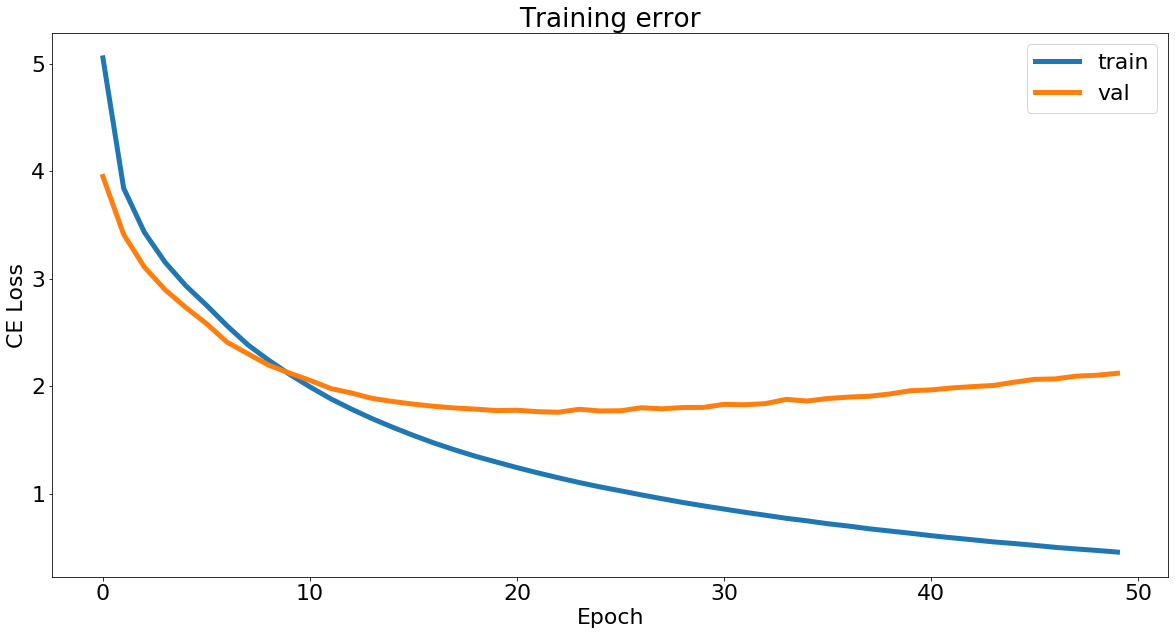

min val loss: 1.7575501799583435


In [15]:
plot_losses(data_dir + 'losses_transformer_512.pickle')

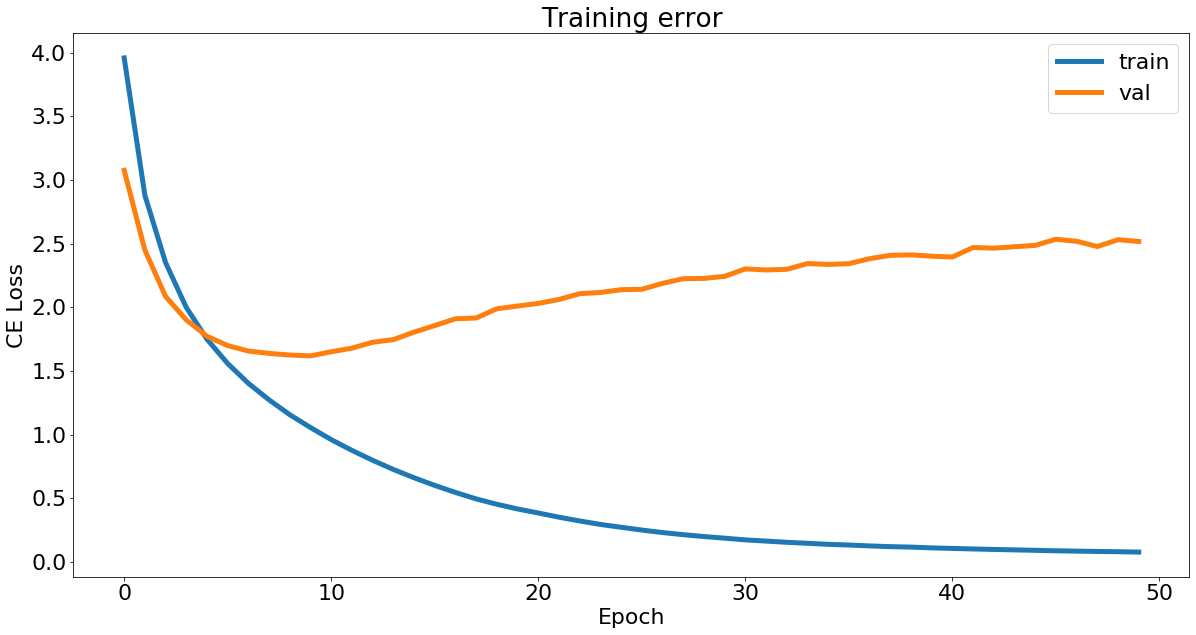

min val loss: 1.618977401405573


In [16]:
plot_losses(data_dir + 'losses_transformer_2048.pickle')

# BLEU Scoring
Use validation set for BLEU scoring

In [ ]:
def flatten_batch_iterator(iterator):
    'Flattens a batch iterator to a list'
    flat = []
    for batch in iterator:
        flat += [row for row in batch]
    return flat

def find_pair(LANG, id_array, txt, ids):
    x = remove_tags(LANG, id_array)
    i = ids.index(x)
    return txt[i]

def tokens_to_tensor(LANG, tokens, reverse=False):
    idx = [LANG.vocab.stoi[t] for t in tokens]
    if reverse: idx = list(reversed(idx))
    return idx

def remove_tags(LANG, idx):
    ignore = [LANG.vocab.stoi['<pad>'], LANG.vocab.stoi['<sos>'], LANG.vocab.stoi['<eos>']]
    return [i for i in idx if i not in ignore]

def tensor_to_tokens(LANG, tensor, reverse=False):
    tensor = remove_tags(LANG, tensor)
    tokens = [LANG.vocab.itos[x] for x in tensor]
    tokens = list(reversed(tokens)) if reverse else tokens
    return tokens

In [ ]:
# Count number of sentences in test set
n_test = len(test_data.examples)

# extract the text sentences from the test set
test_src_txt = [test_data.examples[i].src for i in range(n_test)]
test_trg_txt = [test_data.examples[i].trg for i in range(n_test)]

# extract the word-index sentences from the test set
test_src_idx = [tokens_to_tensor(SRC_LANG, test_src_txt[i]) for i in range(n_test)]
test_trg_idx = [tokens_to_tensor(TAR_LANG, test_trg_txt[i]) for i in range(n_test)]

In [ ]:
def get_pred_tar_pairs(model, iterator):
    'predict on batches and finds the untouched txt sentence which matches the target.'
    # Extract srcs, tars and preds
    TARS = []
    PREDS = []
    SRCS = []
            
    with torch.no_grad():
        for batch in iterator:  
            src = batch.src.transpose(0,1)
            trg = batch.trg.transpose(0,1)
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input)

            # Forward pass
            output = model(src, trg_input, src_mask, trg_mask)
            
            # Argmax over vocab and get the predicted tokens
            pred = output.argmax(dim=2)

            for x in src:
                src_txt = find_pair(SRC_LANG, x.tolist(), test_src_txt, test_src_idx)
                SRCS.append(src_txt)
        
            for x in pred:
                # Convert predicted token to tensor
                pred_tokens = tensor_to_tokens(TAR_LANG, x)
                PREDS.append(pred_tokens)
            
            for x in trg:
                # Find the untouched sentence in the test set
                x = x.tolist()
                tar_tokens = find_pair(TAR_LANG, x, test_trg_txt, test_trg_idx)
                TARS.append(tar_tokens)
    
    return SRCS, PREDS, TARS

from torchnlp.metrics import get_moses_multi_bleu
def bleu(tar, pred): 
    'Calculates moses bleu given two arrays of str tokens'
    tar, pred = ' '.join(tar), ' '.join(pred)
    return get_moses_multi_bleu([tar], [pred])

def bleu_scoring(model, valid_iter):
    print('Predicting on batches...')
    srcs, preds, tars = get_pred_tar_pairs(model, valid_iter)

    print('Computing bleus')
    bleu_scores = np.array([bleu(tar, pred) for pred, tar in zip(preds, tars)])
    bleu_scores = bleu_scores[bleu_scores != None] # Filter out division by 0 errors

    mean_bleu = bleu_scores.mean()
    print('-'*50)
    print('Mean validation BLEU:', mean_bleu)
    print('-'*50)

    for source, target, predicted in list(zip(srcs, tars, preds))[:10]:
        print('Original (de):', ' '.join(reversed(source)))
        print('Target (eng):', ' '.join(target))
        print('Predicted (eng):', ' '.join(predicted))
        print(' ')

    return srcs, preds, tars, bleu_scores, mean_bleu

In [93]:
srcs, preds, tars, bleu_scores, mean_bleu = bleu_scoring(transformer_512, test_iterator_32)

Predicting on batches...
Computing bleus


multi-bleu.perl script returned non-zero exit code
b'\ngzip: /tmp/tmpwjpm9lgz: not in gzip format\nERROR: could not find reference file /tmp/tmpwjpm9lgz at /tmp/tmpo3s1avrj line 32.\n'


--------------------------------------------------
Mean validation BLEU: 27.575256
--------------------------------------------------
Original (de): arbeiter diskutieren neben den schienen .
Target (eng): construction workers having a discussion by the tracks .
Predicted (eng): workers workers are work discussion next the railroad .
 
Original (de): zwei jungen spielen gegeneinander fußball .
Target (eng): two boys play soccer against each other .
Predicted (eng): two boys are soccer together each other .
 
Original (de): zwei fußballmannschaften auf dem feld .
Target (eng): two soccer teams are on the field .
Predicted (eng): two football players are on field field .
 
Original (de): ein hellbrauner hund läuft bergauf .
Target (eng): a light brown dog is running up .
Predicted (eng): a tan tan dog runs running between a
 
Original (de): leute bewundern ein kunstwerk .
Target (eng): people are admiring a work of art .
Predicted (eng): people watch admiring art piece . art .
 
Original 

In [91]:
srcs, preds, tars, bleu_scores, mean_bleu = bleu_scoring(transformer_2048, test_iterator_32)

Predicting on batches...
Computing bleus


Unable to fetch multi-bleu.perl script


--------------------------------------------------
Mean validation BLEU: 29.28604
--------------------------------------------------
Original (de): arbeiter diskutieren neben den schienen .
Target (eng): workers workers are a discussion next the under .
Predicted (eng): construction workers having a discussion by the tracks .
 
Original (de): zwei jungen spielen gegeneinander fußball .
Target (eng): two boys are soccer with each other .
Predicted (eng): two boys play soccer against each other .
 
Original (de): zwei fußballmannschaften auf dem feld .
Target (eng): two soccer players are running the field .
Predicted (eng): two soccer teams are on the field .
 
Original (de): ein hellbrauner hund läuft bergauf .
Target (eng): a tan brown dog is running with some
Predicted (eng): a light brown dog is running up .
 
Original (de): leute bewundern ein kunstwerk .
Target (eng): people are making a piece piece art .
Predicted (eng): people are admiring a work of art .
 
Original (de): ein ju